<a href="https://colab.research.google.com/github/malacosteus/MIPT/blob/main/ML/DT/assignment0_04_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## assignment 04: Decision Tree construction

In [ ]:
# If working in colab, uncomment the following line
# ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_made/homeworks/assignment0_04_tree/tree.py -nc

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd

%load_ext autoreload
%autoreload 2

Let's fix the `random_state` (a.k.a. random seed).

In [ ]:
RANDOM_STATE = 42

__Your ultimate task for today is to impement the `DecisionTree` class and use it to solve classification and regression problems.__

__Specifications:__
- The class inherits from `sklearn.BaseEstimator`;
- Constructor is implemented for you. It has the following parameters:
    * `max_depth` - maximum depth of the tree; `np.inf` by default
    * `min_samples_split` - minimal number of samples in the leaf to make a split; `2` by default;
    * `criterion` - criterion to select the best split; in classification one of `['gini', 'entropy']`, default `gini`; in regression `variance`;

- `fit` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and `y` (`numpy.array` of type float shaped `(n_objects, 1)` in regression; `numpy.array` of type int shaped `(n_objects, 1)` with class labels in classification). It works inplace and fits the `DecisionTree` class instance to the provided data from scratch.

- `predict` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the predicted $\hat{y}$ values. In classification it is a class label for every object (the most frequent in the leaf; if several classes meet this requirement select the one with the smallest class index). In regression it is the desired constant (e.g. mean value for `variance` criterion)

- `predict_proba` method (works only for classification (`gini` or `entropy` criterion). It takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the `numpy.array` of type `float` shaped `(n_objects, n_features)` with class probabilities for every object from `X`. Class $i$ probability equals the ratio of $i$ class objects that got in this node in the training set.

    
__Small recap:__

To find the optimal split the following functional is evaluated:
    
$$G(j, t) = H(Q) - \dfrac{|L|}{|Q|} H(L) - \dfrac{|R|}{|Q|} H(R),$$
    where $Q$ is the dataset from the current node, $L$ and $R$ are left and right subsets defined by the split $x^{(j)} < t$.



1. Classification. Let $p_i$ be the probability of $i$ class in subset $X$ (ratio of the $i$ class objects in the dataset). The criterions are defined as:
    
    * `gini`: Gini impurity $$H(R) = 1 -\sum_{i = 1}^K p_i^2$$
    
    * `entropy`: Entropy $$H(R) = -\sum_{i = 1}^K p_i \log(p_i)$$ (One might use the natural logarithm).
    
2. Regression. Let $y_l$ be the target value for the $R$, $\mathbf{y} = (y_1, \dots, y_N)$ – all targets for the selected dataset $X$.
    
    * `variance`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}(y_j - \text{mean}(\mathbf{y}))^2$$
    
    * `mad_median`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}|y_j - \text{median}(\mathbf{y})|$$
        


**Hints and comments**:

* No need to deal with categorical features, they will not be present.
* Siple greedy recursive procedure is enough. However, you can speed it up somehow (e.g. using percentiles).
* Please, do not copy implementations available online. You are supposed to build very simple example of the Decision Tree.

File `tree.py` is waiting for you. Implement all the needed methods in that file.

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator


def entropy(y):  
    """
    Computes entropy of the provided distribution. Use log(value + eps) for numerical stability

    Parameters
    ----------
    y : np.array of type float with shape (n_objects, n_classes)
        One-hot representation of class labels for corresponding subset

    Returns
    -------
    float
        Entropy of the provided subset
    """
    EPS = 0.0005

    # YOUR CODE HERE

    return 0 if y.shape[0] == 0 else -np.sum(np.mean(y, axis=0) * np.log(np.mean(y, axis=0) + EPS))

def gini(y):
    """
    Computes the Gini impurity of the provided distribution
    
    Parameters
    ----------
    y : np.array of type float with shape (n_objects, n_classes)
        One-hot representation of class labels for corresponding subset
    
    Returns
    -------
    float
        Gini impurity of the provided subset
    """

    # YOUR CODE HERE

    return 0 if y.shape[0] == 0 else 1 - np.sum(np.power(np.mean(y, axis=0), 2))

def variance(y):
    """
    Computes the variance the provided target values subset
    
    Parameters
    ----------
    y : np.array of type float with shape (n_objects, 1)
        Target values vector
    
    Returns
    -------
    float
        Variance of the provided target vector
    """

    # YOUR CODE HERE

    return 0 if y.shape[0] == 0 else np.mean(np.power(y - np.mean(y), 2))

def mad_median(y):
    """
    Computes the mean absolute deviation from the median in the
    provided target values subset
    
    Parameters
    ----------
    y : np.array of type float with shape (n_objects, 1)
        Target values vector
    
    Returns
    -------
    float
        Mean absolute deviation from the median in the provided vector
    """

    # YOUR CODE HERE

    return 0 if y.shape[0] == 0 else np.mean(np.abs(y - np.median(y)))


def one_hot_encode(n_classes, y):
    y_one_hot = np.zeros((len(y), n_classes), dtype=float)
    y_one_hot[np.arange(len(y)), y.astype(int)[:, 0]] = 1.
    return y_one_hot


def one_hot_decode(y_one_hot):
    return y_one_hot.argmax(axis=1)[:, None]


class Node:
    """
    This class is provided "as is" and it is not mandatory to it use in your code.
    """
    def __init__(self, feature_index, threshold, value=0, proba=0, is_leaf=False):
        self.feature_index = feature_index
        self.threshold = threshold
        self.proba = proba
        self.value = value
        self.left_child = None
        self.right_child = None
        self.is_leaf = is_leaf


class DecisionTree(BaseEstimator):
    all_criterions = {
        'gini': (gini, True), # (criterion, classification flag)
        'entropy': (entropy, True),
        'variance': (variance, False),
        'mad_median': (mad_median, False)
    }

    def __init__(self, n_classes=None, max_depth=np.inf, min_samples_split=2, 
                 criterion_name='gini', debug=False):

        assert criterion_name in self.all_criterions.keys(), 'Criterion name must be on of the following: {}'.format(self.all_criterions.keys())
        
        self.n_classes = n_classes
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion_name = criterion_name

        self.depth = 0
        self.root = None # Use the Node class to initialize it later
        self.debug = debug



    def make_split(self, feature_index, threshold, X_subset, y_subset):
        """
        Makes split of the provided data subset and target values using provided feature and threshold

        Parameters
        ----------
        feature_index : int
            Index of feature to make split with
        threshold : float
            Threshold value to perform split
        X_subset : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the selected subset
        y_subset : np.array of type float with shape (n_objects, n_classes) in classification 
                   (n_objects, 1) in regression 
            One-hot representation of class labels for corresponding subset

        Returns
        -------
        (X_left, y_left) : tuple of np.arrays of same type as input X_subset and y_subset
            Part of the provided subset where selected feature x^j < threshold
        (X_right, y_right) : tuple of np.arrays of same type as input X_subset and y_subset
            Part of the provided subset where selected feature x^j >= threshold
        """

        # YOUR CODE HERE

        l_msk = X_subset[:, feature_index] < threshold
        r_msk = X_subset[:, feature_index] >= threshold

        X_left = X_subset[l_msk]
        y_left = y_subset[l_msk]

        X_right = X_subset[r_msk]
        y_right = y_subset[r_msk]

        return (X_left, y_left), (X_right, y_right)

    def make_split_only_y(self, feature_index, threshold, X_subset, y_subset):
        """
        Split only target values into two subsets with specified feature and threshold

        Parameters
        ----------
        feature_index : int
            Index of feature to make split with
        threshold : float
            Threshold value to perform split
        X_subset : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the selected subset
        y_subset : np.array of type float with shape (n_objects, n_classes) in classification 
                   (n_objects, 1) in regression 
            One-hot representation of class labels for corresponding subset

        Returns
        -------
        y_left : np.array of type float with shape (n_objects_left, n_classes) in classification 
                   (n_objects, 1) in regression 
            Part of the provided subset where selected feature x^j < threshold
        y_right : np.array of type float with shape (n_objects_right, n_classes) in classification 
                   (n_objects, 1) in regression 
            Part of the provided subset where selected feature x^j >= threshold
        """

        # YOUR CODE HERE

        l_msk = X_subset[:, feature_index] < threshold
        r_msk = X_subset[:, feature_index] >= threshold

        y_left = y_subset[l_msk]
        y_right = y_subset[r_msk]
    
        return y_left, y_right

    def choose_best_split(self, X_subset, y_subset):
        """
        Greedily select the best feature and best threshold w.r.t. selected criterion
        
        Parameters
        ----------
        X_subset : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the selected subset
        y_subset : np.array of type float with shape (n_objects, n_classes) in classification 
                   (n_objects, 1) in regression 
            One-hot representation of class labels or target values for corresponding subset
        
        Returns
        -------
        feature_index : int
            Index of feature to make split with
        threshold : float
            Threshold value to perform split
        """

        # YOUR CODE HERE

        curr_b_idx = 0
        curr_b_thr = 0
        curr_b_funct = np.inf

        for feature_index in range(X_subset.shape[1]):
            
            all_unique_trh = np.unique(X_subset[:, feature_index])
            for cur_threshold in all_unique_trh:

                y_l, y_r = self.make_split_only_y(feature_index, cur_threshold, X_subset, y_subset)
                # we can simplify functional computation because self.criterion(y_subset) is same in every loop itertion
                # so, maximizing of original functional is equivalent to minimizing len(y_left) * self.criterion(y_left) + len(y_right) * self.criterion(y_right)
                curr_funct = y_l.size * self.criterion(y_l) + y_r.size * self.criterion(y_r)

                if curr_funct < curr_b_funct:
                    curr_b_thr = cur_threshold
                    curr_b_idx = feature_index
                    curr_b_funct = curr_funct
                    
        return curr_b_idx, curr_b_thr
    
    def make_tree(self, X_subset, y_subset):
        """
        Recursively builds the tree
        
        Parameters
        ----------
        X_subset : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the selected subset
        y_subset : np.array of type float with shape (n_objects, n_classes) in classification 
                   (n_objects, 1) in regression 
            One-hot representation of class labels or target values for corresponding subset
        
        Returns
        -------
        root_node : Node class instance
            Node of the root of the fitted tree
        """

        # YOUR CODE HERE

        if self.classification:
            n_lf = lambda y: Node(0, 0, value=np.argmax(np.sum(y, axis=0)), proba=np.sum(y, axis=0) / y.shape[0], is_leaf=True)
        else:
            n_lf = lambda y: Node(0, 0, value=np.mean(y) if self.criterion_name=="variance" else np.median(y), is_leaf=True)
        
        if (X_subset.shape[0] < self.min_samples_split) or (self.depth == self.max_depth):
            self.depth -= 1
            return n_lf(y_subset)
        
        feature_index, threshold = self.choose_best_split(X_subset, y_subset)
        (X_l, y_l), (X_r, y_r) = self.make_split(feature_index, threshold, X_subset, y_subset)
        
        if X_l.shape[0] == 0 or X_r.shape[0] == 0:
            self.depth -= 1
            return n_lf(y_subset)
        
        new_node = Node(feature_index, threshold)
        self.depth += 1
        new_node.right_child = self.make_tree(X_r, y_r)
        self.depth += 1
        new_node.left_child = self.make_tree(X_l, y_l)
        
        self.depth -= 1
        return new_node
        
    def fit(self, X, y):
        """
        Fit the model from scratch using the provided data
        
        Parameters
        ----------
        X : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the data to train on
        y : np.array of type int with shape (n_objects, 1) in classification 
                   of type float with shape (n_objects, 1) in regression 
            Column vector of class labels in classification or target values in regression

        """
        assert len(y.shape) == 2 and len(y) == len(X), 'Wrong y shape'
        self.criterion, self.classification = self.all_criterions[self.criterion_name]
        if self.classification:
            if self.n_classes is None:
                self.n_classes = len(np.unique(y))
            y = one_hot_encode(self.n_classes, y)

        self.root = self.make_tree(X, y)

    def predict(self, X):
        """
        Predict the target value or class label  the model from scratch using the provided data
        
        Parameters
        ----------
        X : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the data the predictions should be provided for
        Returns
        -------
        y_predicted : np.array of type int with shape (n_objects, 1) in classification 
                   (n_objects, 1) in regression 
            Column vector of class labels in classification or target values in regression

        """

        # YOUR CODE HERE

        y_predicted = np.zeros(X.shape[0])
        i = 0
        for chk_node in X:
            cur_node = self.root
            while not cur_node.is_leaf:
                if  chk_node[cur_node.feature_index] < cur_node.threshold:
                    cur_node = cur_node.left_child
                else:
                    cur_node = cur_node.right_child
            y_predicted[i] = cur_node.value
            i += 1
        return y_predicted

    def predict_proba(self, X):
        """
        Only for classification
        Predict the class probabilities using the provided data

        Parameters
        ----------
        X : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the data the predictions should be provided for
        Returns
        -------
        y_predicted_probs : np.array of type float with shape (n_objects, n_classes)
            Probabilities of each class for the provided objects

        """
        assert self.classification, 'Available only for classification problem'

        # YOUR CODE HERE

        y_predicted_probs = np.ndarray((X.shape[0], self.n_classes))
        i = 0
        for chk_node in X:
            cur_node = self.root
            while not cur_node.is_leaf:
                if  chk_node[cur_node.feature_index] < cur_node.threshold:
                    cur_node = cur_node.left_child
                else:
                    cur_node = cur_node.right_child
            y_predicted_probs[i] = cur_node.proba
            i += 1

        return y_predicted_probs

### Check yourself

In [ ]:
#from tree import entropy, gini, variance, mad_median, DecisionTree

#### Simple check

In [ ]:
X = np.ones((4, 5), dtype=float) * np.arange(4)[:, None]
y = np.arange(4)[:, None] + np.asarray([0.2, -0.3, 0.1, 0.4])[:, None]
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')

(X_l, y_l), (X_r, y_r) = class_estimator.make_split(1, 1., X, y)

assert np.array_equal(X[:1], X_l)
assert np.array_equal(X[1:], X_r)
assert np.array_equal(y[:1], y_l)
assert np.array_equal(y[1:], y_r)

#### Classification problem

In [ ]:
digits_data = load_digits().data
digits_target = load_digits().target[:, None] # to make the targets consistent with our model interfaces
X_train, X_test, y_train, y_test = train_test_split(digits_data, digits_target, test_size=0.2, random_state=RANDOM_STATE)

In [ ]:
assert len(y_train.shape) == 2 and y_train.shape[0] == len(X_train)

In [ ]:
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_gini = accuracy_score(y_test, ans)
print(accuracy_gini)

0.8638888888888889


In [ ]:
reference = np.array([0.09027778, 0.09236111, 0.08333333, 0.09583333, 0.11944444,
       0.13888889, 0.09930556, 0.09444444, 0.08055556, 0.10555556])

In [ ]:
class_estimator = DecisionTree(max_depth=10, criterion_name='entropy')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_entropy = accuracy_score(y_test, ans)
print(accuracy_entropy)

0.8805555555555555


In [ ]:
assert  0.84 < accuracy_gini < 0.9
assert  0.86 < accuracy_entropy < 0.9

# wasn't able to complete this assert 
#assert np.sum(np.abs(class_estimator.predict_proba(X_test).mean(axis=0) - reference)) < 1e-4

In [ ]:
np.sum(np.abs(class_estimator.predict_proba(X_test).mean(axis=0) - reference))

0.024999993333333317

Let's use 5-fold cross validation (`GridSearchCV`) to find optimal values for `max_depth` and `criterion` hyperparameters.

In [ ]:
param_grid = {'max_depth': range(3,11), 'criterion_name': ['gini', 'entropy']}
gs = GridSearchCV(DecisionTree(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-2)

In [ ]:
%%time
gs.fit(X_train, y_train)

CPU times: user 3min 30s, sys: 1.45 s, total: 3min 31s
Wall time: 3min 33s


GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['gini', 'entropy'],
                         'max_depth': range(3, 11)},
             scoring='accuracy')

In [ ]:
gs.best_params_

{'criterion_name': 'entropy', 'max_depth': 8}

In [ ]:
assert gs.best_params_['criterion_name'] == 'entropy'
assert 6 < gs.best_params_['max_depth'] < 9

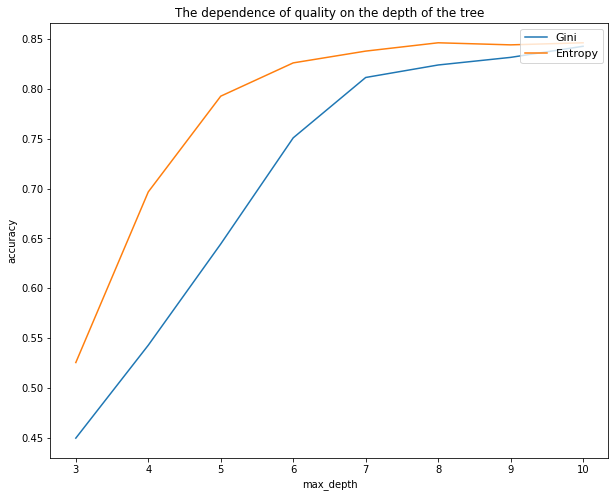

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of quality on the depth of the tree")
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][:8], label='Gini')
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][8:], label='Entropy')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('accuracy')
plt.show()

#### Regression problem

In [ ]:
regr_data = load_boston().data
regr_target = load_boston().target[:, None] # to make the targets consistent with our model interfaces
RX_train, RX_test, Ry_train, Ry_test = train_test_split(regr_data, regr_target, test_size=0.2, random_state=RANDOM_STATE)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
regressor = DecisionTree(max_depth=10, criterion_name='mad_median')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_mad = mean_squared_error(Ry_test, predictions_mad)
print(mse_mad)

12.655955882352941


In [ ]:
regressor = DecisionTree(max_depth=10, criterion_name='variance')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_var = mean_squared_error(Ry_test, predictions_mad)
print(mse_var)

10.322185651177042


In [ ]:
assert 9 < mse_mad < 20
assert 8 < mse_var < 12

In [ ]:
param_grid_R = {'max_depth': range(2,9), 'criterion_name': ['variance', 'mad_median']}

In [ ]:
gs_R = GridSearchCV(DecisionTree(), param_grid=param_grid_R, cv=5, scoring='neg_mean_squared_error', n_jobs=-2)
gs_R.fit(RX_train, Ry_train)

GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['variance', 'mad_median'],
                         'max_depth': range(2, 9)},
             scoring='neg_mean_squared_error')

In [ ]:
gs_R.best_params_

{'criterion_name': 'mad_median', 'max_depth': 5}

In [ ]:
assert gs_R.best_params_['criterion_name'] == 'mad_median'
assert 3 < gs_R.best_params_['max_depth'] < 7

In [ ]:
var_scores = gs_R.cv_results_['mean_test_score'][:7]
mad_scores = gs_R.cv_results_['mean_test_score'][7:]

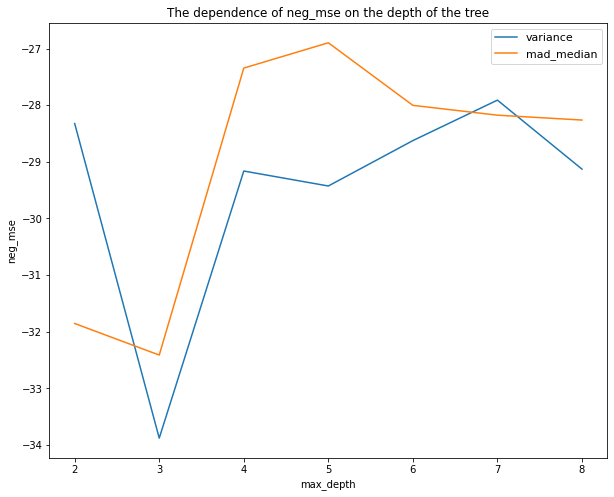

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of neg_mse on the depth of the tree")
plt.plot(np.arange(2,9), var_scores, label='variance')
plt.plot(np.arange(2,9), mad_scores, label='mad_median')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('neg_mse')
plt.show()